<!-- # Notebook for Scor-O - Viz
- reads in the table of season's scores and outputs a vizualization of the density of result combinations -->

# Scoragmi Visualization Book
- Creates heatmap visualization of all combinations of scores in D1 men's and women's hockey for the season

- Men's schedule download not working currently - outputs empty - locally stored tables work fine, woman's results downloader workes fine



In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from dateutil.relativedelta import relativedelta
import datetime
from bs4 import BeautifulSoup
import requests
import re
# import PowerNorm  # for log scaling colorbars
from matplotlib.colors import PowerNorm  # for log scaling colorbars


# store current date as sring (format 9/28/83)
today = datetime.datetime.now().strftime('%m/%d/%y')
# string with no slashes
today_ns = today.replace('/', '')

figure_ratio = (10, 10)

# Define paths
scor_o_path = os.path.join('..', '..', 'TEMP', 'IMAGES')


####################
# TO USE LOCAL RESULTS TABLE ##

# Load Results Table - in the format of CHN Schedule Tables
# filename = 'Week 1 Scores'
# data_path = os.path.join('..', 'data', 'schedule', f'{filename}.csv')
# data = pd.read_csv(data_path) # Load to dataframe

# # data.head() # Check Dataframe


############ USE WEB SCRAPING TO GET RESULTS TABLE ############
current_year_url = 'https://www.collegehockeynews.com/schedules/?season=20242025'

In [2]:
### SET COLOR PALLETTE FOR PLOTS

# set_pallette = "viridis"
# set_pallette = "plasma"
# set_pallette = "inferno"
# set_pallette = "magma"
set_pallette = "cividis" ####  <----
# set_pallette = "coolwarm"
# set_pallette = "Pastel1"
# set_pallette = "Set2"
# set_pallette = "tab10"

# Reverse the color pallete
# set_pallette = set_pallette + "_r"


### Download Current Results Table from College Hockey News
- Something not working, appears to download the schedule correctly but something goes wrong when sending to data transformation
- code taken from roster_scrape_and_clean notebook

<!-- ## Data Transform -->

In [3]:
## Functions
### Parse the current season schedule / results page
############ USE WEB SCRAPING TO GET RESULTS TABLE ############
current_year_url = 'https://www.collegehockeynews.com/schedules/?season=20242025'

def parse_current_season(url):
        # Initialize variables
    current_date = None
    current_conference = None
    game_notes = None

    # Initialize an empty list to hold the data
    data = []

    # Parse the page with BeautifulSoup
    # Get the page with requests
    response = requests.get(url)

    # Create a BeautifulSoup object
    soup = BeautifulSoup(response.text, 'html.parser')

    # select the table or tables
    tables = soup.find_all('table')

    rows = soup.find_all('tr')

    # Loop through each row to find relevant information
    for row in rows:
        # Check for date row
        if row.get('class') == ['stats-section']:
            current_date = row.find('td').text.strip()
        # Check for conference row
        elif row.get('class') == ['sked-header']:
            current_conference = row.find('td').text.strip()
        # Check for game notes
        elif len(row.find_all('td')) == 2:
            game_notes = row.find_all('td')[1].text.strip()
        # Process rows with game data
        elif row.get('valign') == 'top':
            cells = row.find_all('td')
            if len(cells) >= 9:
                home_team = cells[0].text.strip()
                # Remove any hyphens from the team name
                home_team = home_team.replace('-', ' ')
                home_team_link = cells[0].find('a')['href'] if cells[0].find('a') else None
                home_score = cells[1].text.strip()
                away_team = cells[3].text.strip()
                away_team_link = cells[3].find('a')['href'] if cells[3].find('a') else None
                away_score = cells[4].text.strip()
                ot = cells[5].text.strip()
                box_link = cells[7].find('a')['href'] if cells[7].find('a') else None
                metrics_link = cells[8].find('a')['href'] if cells[8].find('a') else None
                # Capture Game Notes
                game_notes_cell = cells[-1].find('small')
                game_notes = game_notes_cell.text.strip() if game_notes_cell else None

                # Append data to the list
                data.append([current_date, current_conference, game_notes, home_team, home_team_link, home_score, away_team, away_team_link, away_score, ot, box_link, metrics_link])
                game_notes = None  # Reset game notes for the next row
    return data

## call the function
data = parse_current_season(current_year_url)


# Create a dataframe from the list

columns = ['Date', 'Conference', 'Game_Notes', 'Away_Team', 'Away_Team_Link', 'Away_Score', 'Home_Team', 'Home_Team_Link', 'Home_Score', 'OT', 'Box_Link', 'Metrics_Link']
df = pd.DataFrame(data, columns=columns)
            
## Extract the day of the week from the date and save in new column
df['Day'] = pd.to_datetime(df['Date']).dt.day_name()
# remove day of the week from date
# format data column as YYYY-MM-DD
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

### Create a new column for the game ID
## Game ID will be a combination of the date and abbreviated team names

# Loop to abbreviate the team names
for row in df.itertuples():
    home_team = row.Home_Team
    away_team = row.Away_Team
    home_team_abbr = home_team.split(' ')[-1]
    away_team_abbr = away_team.split(' ')[-1]
    # Remove any hyphens from the team name if there are any
    home_team_abbr = home_team_abbr.replace('-', ' ')
    away_team_abbr = away_team_abbr.replace('-', ' ')
    game_id = f'{row.Date}-{home_team_abbr}-{away_team_abbr}'
    df.loc[row.Index, 'Game_ID'] = game_id

# Create a new column for the game ID
df['Game_ID'] = df['Game_ID'].str.replace(',', '')

# Remove any hyphens from the team names if any
df['Home_Team'] = df['Home_Team'].str.replace('-', ' ')
df['Away_Team'] = df['Away_Team'].str.replace('-', ' ')

# Apply the function to the DataFrame
df['Game_ID'] = df.apply(lambda row: f'{row.Date}-{row.Home_Team}-{row.Away_Team}', axis=1)

## Filter out games that have not been played yet
df = df[df['Home_Score'] != '']

# Replace Nan values in metrics column with empty string
df['Metrics_Link'] = df['Metrics_Link'].fillna('')

In [4]:
# Print length of dataframe before and after filtering for exhibition games
print(f'Length of dataframe before filtering for exhibition games: {len(df)}')

# Filter out exhibition games - Conference = Exhibition
df = df[df['Conference'] != 'Exhibition']

print(f'Length of dataframe after filtering for exhibition games: {len(df)}')


Length of dataframe before filtering for exhibition games: 836
Length of dataframe after filtering for exhibition games: 783


In [5]:
print(len(df))

# Store the dataframe as games_df
data = df.copy()

# df.tail(10)

# save the dataframe to a csv file for manual review
# df.to_csv('../TEMP/season_table_test.csv')



783


In [6]:
# data.info()
# data.head()

#### OLD CODE - MAY DELETE

In [7]:
# # Set the URL to scrape
# url_base = 'https://www.collegehockeynews.com/schedules/?season=' # Link to the 2022-2023 season with all results

# url_season = '20242025' #### Set the season varriable portion of the url 
# file_tag = f'd1_mens_results_thru{today}'#### string to add to file names and whatnot

# # Set output directory
# output_dir = os.path.join('..', 'TEMP')

# ## Construct the url to feed to parser
# url = url_base + url_season

# # Get the page with requests
# response = requests.get(url)

# # Create a BeautifulSoup object
# soup = BeautifulSoup(response.text, 'html.parser')

# # select the table or tables
# tables = soup.find_all('table')

# # Initialize variables
# current_date = None
# current_conference = None
# game_notes = None

# # Initialize an empty list to hold the data
# data = []

# # Parse the table with BeautifulSoup

# rows = soup.find_all('tr')

# # Loop through each row to find relevant information
# for row in rows:
#     # Check for date row
#     if row.get('class') == ['stats-section']:
#         current_date = row.find('td').text.strip()
#     # Check for conference row
#     elif row.get('class') == ['sked-header']:
#         current_conference = row.find('td').text.strip()
#     # Check for game notes
#     elif len(row.find_all('td')) == 2:
#         game_notes = row.find_all('td')[1].text.strip()
#     # Process rows with game data
#     elif row.get('valign') == 'top':
#         cells = row.find_all('td')
#         if len(cells) >= 9:
#             home_team = cells[0].text.strip()
#             home_team_link = cells[0].find('a')['href'] if cells[0].find('a') else None
#             home_score = cells[1].text.strip()
#             away_team = cells[3].text.strip()
#             away_team_link = cells[3].find('a')['href'] if cells[3].find('a') else None
#             away_score = cells[4].text.strip()
#             ot = cells[5].text.strip()
#             box_link = cells[7].find('a')['href'] if cells[7].find('a') else None
#             metrics_link = cells[8].find('a')['href'] if cells[8].find('a') else None
#              # Capture Game Notes
#             game_notes_cell = cells[-1].find('small')
#             game_notes = game_notes_cell.text.strip() if game_notes_cell else None

#             # Append data to the list
#             data.append([current_date, current_conference, game_notes, home_team, home_team_link, home_score, away_team, away_team_link, away_score, ot, box_link, metrics_link])
#             game_notes = None  # Reset game notes for the next row
            

# # Create a DataFrame
# columns = ['Date', 'Conference', 'Game_Notes', 'Away_Team', 'Away_Team_Link', 'Away_Score', 'Home_Team', 'Home_Team_Link', 'Home_Score',  'OT', 'Box_Link', 'Metrics_Link']
# df = pd.DataFrame(data, columns=columns)

# ## Extract the day of the week from the date and save in new column
# df['Day'] = pd.to_datetime(df['Date']).dt.day_name()
# # remove day of the week from date
# # format data column as YYYY-MM-DD
# df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

# ### Create a new column for the game ID
# ## Game ID will be a combination of the date and abbreviated team names

# # Function to abbreviate the team names
# for row in df.itertuples():
#     home_team = row.Home_Team
#     away_team = row.Away_Team
#     home_team_abbr = home_team.split(' ')[-1]
#     away_team_abbr = away_team.split(' ')[-1]
#     game_id = f'{row.Date}_{home_team_abbr}_{away_team_abbr}'
#     df.loc[row.Index, 'Game_ID'] = game_id

# # Create a new column for the game ID
# df['Game_ID'] = df['Game_ID'].str.replace(',', '')

# # Apply the function to the DataFrame
# df['Game_ID'] = df.apply(lambda row: f'{row.Date}_{row.Home_Team}_{row.Away_Team}', axis=1)

# ## Remove periods from team names
# df['Home_Team'] = df['Home_Team'].str.replace('.', '')
# df['Away_Team'] = df['Away_Team'].str.replace('.', '')
# # Replace Dashes with spaces
# df['Home_Team'] = df['Home_Team'].str.replace('-', ' ')
# df['Away_Team'] = df['Away_Team'].str.replace('-', ' ')
# # Replace ' with space
# df['Home_Team'] = df['Home_Team'].str.replace("'", '')
# df['Away_Team'] = df['Away_Team'].str.replace("'", '')


# # Strip whitespace
# df['Home_Team'] = df['Home_Team'].str.strip()
# df['Away_Team'] = df['Away_Team'].str.strip()

# data = df.copy() # Save a copy of the data
# data.head() # Check Dataframe


In [8]:

# # Filter out exhibition games
# # filtered_data = data[data['Conference'] != 'Exhibition']
# # filtered_data = data[data['Conference'] != 'Exhibition']

# # Determine the maximum scores for both home and away teams to set up the axes
# # and make sure they are integers
# max_home_score = filtered_data['Home_Score'].max()
# max_away_score = filtered_data['Away_Score'].max()
# max_home_score, max_away_score = int(max_home_score), int(max_away_score)

# # Calculate the total home wins (Home_Score > Away_Score)
# home_wins = len(filtered_data[filtered_data['Home_Score'] > filtered_data['Away_Score']])

# # Calculate the total away wins (Away_Score > Home_Score)
# away_wins = len(filtered_data[filtered_data['Away_Score'] > filtered_data['Home_Score']])

# # Calculate ties, if any (optional)
# ties = len(filtered_data[filtered_data['Home_Score'] == filtered_data['Away_Score']])



# # Create a pivot table to aggregate game counts for each score combination
# score_combinations = pd.pivot_table(filtered_data, index='Home_Score', columns='Away_Score', values='Date', aggfunc='count', fill_value=0)

# # Fill in any missing score combinations with zeros (in case some scores don't appear in the dataset)
# all_scores = np.arange(0, max(max_home_score, max_away_score) + 1)  # +1 to include the max score itself
# score_combinations = score_combinations.reindex(index=all_scores, columns=all_scores, fill_value=0)
# # Make sure the numbers in the headers pivot table are integers
# score_combinations = score_combinations.astype(int)
# score_combinations

# # data.head()

<!-- ## Basic Plotting Code
- taken from 2023-24 project workbook -->

In [9]:
# # look for Exhibition games and filter them out
# # Value COunt of conference
# # print(data['Conference'].value_counts())
# print(len(data)) # Check length of data

# # Filter out exhibition games
# filtered_data = data[data['Conference'] != 'Exhibition']

# # check the value counts of the conference column
# print(filtered_data['Conference'].value_counts())
# print(len(filtered_data)) # Check length of filtered_data

# # # Value COunts of Scores
# # filtered_data['Home_Score'].value_counts()
# # filtered_data['Away_Score'].value_counts()

## Mens D1 Plot - Working Copy

#### Hotfix because home and away are being assigned incorreectly

In [10]:
######### HOTFIX - Home and away are switched in the data ########
####### Switch Home and Away Scores, teams, and links, ect. ########

# # Switch Home and Away Scores
# data['Home_Score'], data['Away_Score'] = data['Away_Score'], data['Home_Score']
# data['Home_Team'], data['Away_Team'] = data['Away_Team'], data['Home_Team']
# data['Home_Team_Link'], data['Away_Team_Link'] = data['Away_Team_Link'], data['Home_Team_Link']


## SHOULD BE UNNECESSARY NOW THAT THE DATA IS CLEANED UP

# data.head()

##### Hide Code

In [ ]:



## NOT NESS FOR WOMAN'S TABLE FOR SOME REASON - BREAKS WHEN UNCOMMENTED
# Filter out exhibition games 
# filtered_data = data[data['Conference'] != 'Exhibition']
filtered_data = data.copy()

# make sure Home_Score and Away_Score are integers
filtered_data['Home_Score'] = filtered_data['Home_Score'].astype(int)
filtered_data['Away_Score'] = filtered_data['Away_Score'].astype(int)

# Determine the maximum scores for both home and away teams to set up the axes
# and make sure they are integers
max_home_score = filtered_data['Home_Score'].max()
max_away_score = filtered_data['Away_Score'].max()
max_home_score, max_away_score = int(max_home_score), int(max_away_score)

# Calculate the total home wins (Home_Score > Away_Score)
home_wins = len(filtered_data[filtered_data['Home_Score'] > filtered_data['Away_Score']])

# Calculate the total away wins (Away_Score > Home_Score)
away_wins = len(filtered_data[filtered_data['Away_Score'] > filtered_data['Home_Score']])

# Calculate ties, if any (optional)
ties = len(filtered_data[filtered_data['Home_Score'] == filtered_data['Away_Score']])



# Create a pivot table to aggregate game counts for each score combination
score_combinations = pd.pivot_table(filtered_data, index='Home_Score', columns='Away_Score', values='Date', aggfunc='count', fill_value=0)

# Fill in any missing score combinations with zeros (in case some scores don't appear in the dataset)
all_scores = np.arange(0, max(max_home_score, max_away_score) + 1)  # +1 to include the max score itself
score_combinations = score_combinations.reindex(index=all_scores, columns=all_scores, fill_value=0)
# Make sure the numbers in the headers pivot table are integers
score_combinations = score_combinations.astype(int)
# score_combinations

# data.head()


Away_Score,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Home_Score,,,,,,,,,,,,,,,
0,2,14,7,15,6,4,3,1,0,0,0,0,0,0,0
1,10,12,28,21,29,18,6,1,1,0,0,0,0,0,0
2,13,34,18,45,30,18,8,2,0,0,0,0,0,0,0
3,15,29,48,24,24,14,11,4,1,0,0,0,0,0,0
4,13,38,24,34,8,9,5,2,0,0,0,0,0,0,0
5,5,7,31,9,5,1,2,1,1,1,0,0,0,0,0
6,3,11,9,13,0,4,1,0,0,0,1,0,0,0,0
7,1,3,2,2,3,1,0,0,0,0,0,0,0,0,0
8,3,2,3,2,0,0,0,0,0,0,0,0,0,0,0


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

date = today
# Define figure size to maintain a 4:5 ratio while ensuring the heatmap grid stays 1:1
figure_ratio = (8, 10)  # Adjusted for mobile-friendly aspect ratio
# Create Function to plot the scorigami
def plot_scorigami(score_combinations, home_wins, away_wins, ties, date):

    # Customizing the colormap with transparency for zeros
    cmap = sns.color_palette(palette=set_pallette, as_cmap=True)
    cmap_with_transparency = ListedColormap([(0,0,0,0)] + [cmap(i) for i in range(1, cmap.N)])

    # Create a figure with constrained layout to ensure the grid aspect stays 1:1
    fig = plt.figure(figsize=figure_ratio)

    # Create the title
    plt.suptitle("2024-25 Men's D1 Hockey Scorigami", fontsize=24, fontweight='bold', color='black', y=0.98)
    # Create Subtitle for the week #
    plt.title(f'Week 1', fontsize=18, fontweight='bold', color='black', y=0.95)

    # Create a new axis for the heatmap with the grid maintaining a 1:1 aspect ratio
    # ax1 = fig.add_axes([0.05, 0.2, 0.98, 0.6])  # Adjusted placement to reduce whitespace
    # Placement for mobile-friendly aspect ratio
    ax1 = fig.add_axes([0.05, 0.05, 0.975, 0.995])  # Adjusted placement to reduce whitespace
    sns.heatmap(score_combinations, annot=True, mask=None, cmap=cmap_with_transparency, fmt="d", linewidths=.25, 
                linecolor='gray', cbar=False, square=True, ax=ax1)

    # Invert y-axis to ensure 0 is at the bottom
    ax1.invert_yaxis()

    # Axis labels
    ax1.set_xlabel('Away', fontsize=12) #, labelpad=10)
    # Rotate the y-axis label 90 degrees for better readability
    ax1.set_ylabel('Home', fontsize=12, rotation=90, labelpad=10)



    # ax1.set_ylabel('Home', fontsize=12) # labelpad=10)

    # Customize tick labels
    ax1.set_xticks(np.arange(0.5, len(all_scores)+0.5, 1))
    ax1.set_xticklabels(all_scores, fontsize=14)
    ax1.set_yticks(np.arange(0.5, len(all_scores)+0.5, 1))
    ax1.set_yticklabels(all_scores, fontsize=14)

    # Add a diagonal line for home vs away parity
    ax1.plot([0, len(all_scores)], [0, len(all_scores)], color='red', linestyle='--', linewidth=1)

    # # Create a new axis for the color bar below the heatmap
    # ax2 = fig.add_axes([0.15, 0.1, 0.7, 0.02])  # Adjust placement for color bar
    # cbar = plt.colorbar(ax1.collections[0], cax=ax2, orientation='horizontal')
    # Restored the color bar label for clarity
    # cbar.set_label('Game Frequency', fontsize=14) # Uncomment to add a label - DUMB

    # Add the leaderboard box below the color bar
    props = dict(boxstyle='round,pad=0.5', facecolor='lightgray', edgecolor='black')
    leaderboard_text = f'Home Wins: {home_wins} | Away Wins: {away_wins} | Ties: {ties}'
    plt.text(0.5, 0.04, leaderboard_text, fontsize=14, color='black', ha='center', bbox=props, transform=fig.transFigure)

    # Add data source and date at the very bottom with better padding
    plt.figtext(0.5, 0.005, f'Data Source: CollegeHockeyNews.com | Games Through {date} | Shootouts are Ingored', fontsize=10, color='black', ha='center')

    # Adjust the layout to reduce overall whitespace
    plt.subplots_adjust(top=.90, bottom=0.5, left=0.1, right=0.9, hspace=0.2)

    # Save the plot as an image
    plt.savefig(os.path.join(scor_o_path, f'men_scorigami_{today_ns}.png'), dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()


#### Output - Men's

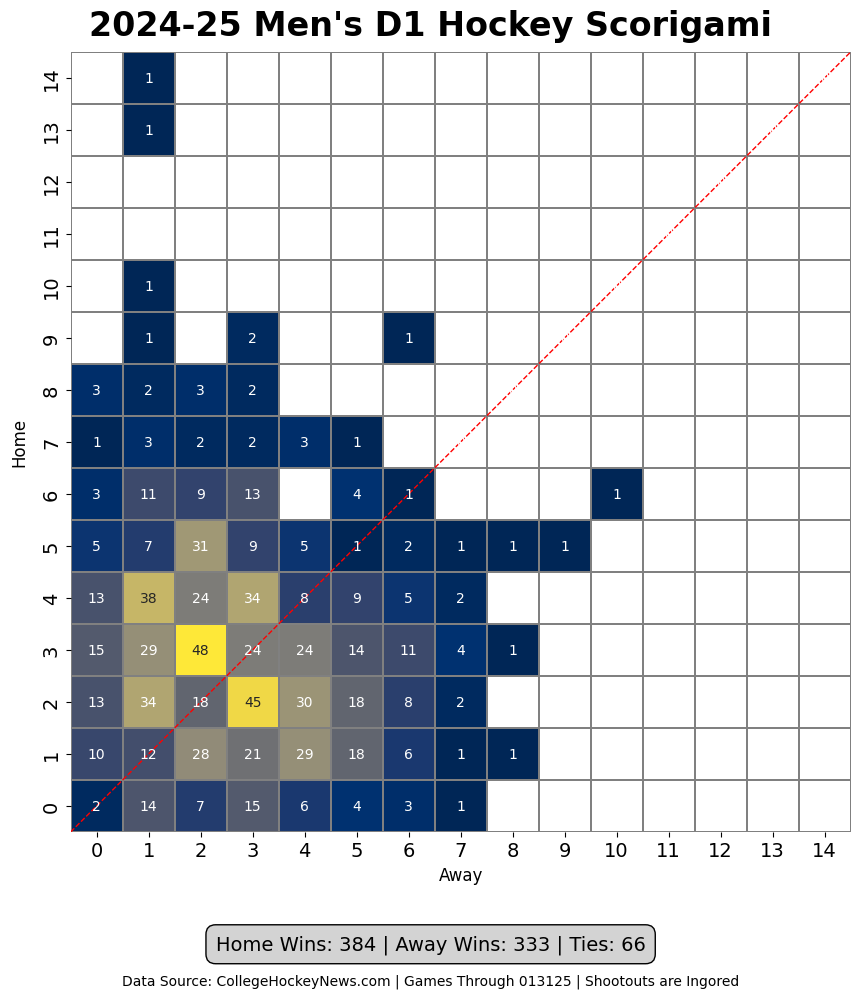

In [13]:
## Call the function
plot_scorigami(score_combinations, home_wins, away_wins, ties, today_ns)

## Woman's Hockey Results Scrape

###### Hide Code

In [14]:
from bs4 import BeautifulSoup
import requests
import re

# url of CHN woman's results page - Only includes results from Oct 1 on - need to manually get and add September games
urls = ['https://www.collegehockeynews.com/women/schedule.php?date=20240920', 
        'https://www.collegehockeynews.com/women/schedule.php?date=20240927', 
        'https://www.collegehockeynews.com/women/schedule.php?season=20242025']

# url = 'https://www.collegehockeynews.com/women/schedule.php?season=20242025'

def get_game_data(url):
    # Get the page with requests
    response = requests.get(url)

    # Create a BeautifulSoup object
    soup = BeautifulSoup(response.text, 'html.parser')

    # select the table or tables
    tables = soup.find_all('table')

    # Initialize variables
    current_date = None
    current_conference = None
    game_notes = None

    # Initialize an empty list to hold the data
    data = []

    # Parse the table with BeautifulSoup

    rows = soup.find_all('tr')

    # Loop through each row to find relevant information
    for row in rows:
        # Check for date row
        if row.get('class') == ['stats-section']:
            current_date = row.find('td').text.strip()
        # Check for conference row
        elif row.get('class') == ['sked-header']:
            current_conference = row.find('td').text.strip()
        # Check for game notes
        elif len(row.find_all('td')) == 2:
            game_notes = row.find_all('td')[1].text.strip()
        # Process rows with game data
        elif row.get('valign') == 'top':
            cells = row.find_all('td')
            if len(cells) >= 9:
                home_team = cells[0].text.strip()
                home_team_link = cells[0].find('a')['href'] if cells[0].find('a') else None
                home_score = cells[1].text.strip()
                away_team = cells[3].text.strip()
                away_team_link = cells[3].find('a')['href'] if cells[3].find('a') else None
                away_score = cells[4].text.strip()
                ot = cells[5].text.strip()
                box_link = cells[7].find('a')['href'] if cells[7].find('a') else None
                metrics_link = cells[8].find('a')['href'] if cells[8].find('a') else None
                # Capture Game Notes
                game_notes_cell = cells[-1].find('small')
                game_notes = game_notes_cell.text.strip() if game_notes_cell else None

                # Append data to the list
                data.append([current_date, current_conference, game_notes, home_team, home_team_link, home_score, away_team, away_team_link, away_score, ot, box_link, metrics_link])
                game_notes = None  # Reset game notes for the next row

    return data

# Initialize an empty list to hold all the data
data = []

# loop through all the urls
for url in urls:
    data += get_game_data(url)
                


# Create a DataFrame
columns = ['Date', 'Conference', 'Game_Notes', 'Away_Team', 'Away_Team_Link', 'Away_Score', 'Home_Team', 'Home_Team_Link', 'Home_Score',  'OT', 'Box_Link', 'Metrics_Link']
df = pd.DataFrame(data, columns=columns)

# # Clean Team names for ease of use (remove any dashes, ' or periods)
df['Away_Team'] = df['Away_Team'].str.replace("'", "").str.replace(".", "").str.replace("-", " ")
df['Home_Team'] = df['Home_Team'].str.replace("'", "").str.replace(".", "").str.replace("-", " ")

print('Original Length:', len(df))

# Drop any duplicate rows
df.drop_duplicates(inplace=True)

print('After Dropping Duplicates:', len(df))

# Drop Exhibition games
df = df[~df['Conference'].str.contains('Exhibition')]

print('After Dropping Exhibition Games:', len(df))
# df.head(5)
# Rename to w_results_df
# w_results_df = df

Original Length: 771
After Dropping Duplicates: 741
After Dropping Exhibition Games: 730


In [15]:
######### HOTFIX - Home and away are switched in the data ########
####### Switch Home and Away Scores, teams, and links, ect. ########
data = df.copy()

# Switch Home and Away Scores
data['Home_Score'], data['Away_Score'] = data['Away_Score'], data['Home_Score']
data['Home_Team'], data['Away_Team'] = data['Away_Team'], data['Home_Team']
data['Home_Team_Link'], data['Away_Team_Link'] = data['Away_Team_Link'], data['Home_Team_Link']
### NEEDED FOR WOMAN'S DATA, NOT NESS FOR MEN'S DATA

# data.head()

In [16]:
# Filter out exhibition games 
filtered_data = data.copy()

# Ensure df.copy() is correctly used
# filtered_data = data[data['Conference'] != 'Exhibition']

# Check if the 'Home_Score' and 'Away_Score' columns exist and have numeric data
if 'Home_Score' not in filtered_data.columns or 'Away_Score' not in filtered_data.columns:
    raise ValueError("Home_Score or Away_Score columns are missing.")

# Check for missing or non-numeric values in the score columns
filtered_data['Home_Score'] = pd.to_numeric(filtered_data['Home_Score'], errors='coerce')
filtered_data['Away_Score'] = pd.to_numeric(filtered_data['Away_Score'], errors='coerce')

# Drop rows with missing values in scores
filtered_data.dropna(subset=['Home_Score', 'Away_Score'], inplace=True)

# Ensure all score values are integers
filtered_data['Home_Score'] = filtered_data['Home_Score'].astype(int)
filtered_data['Away_Score'] = filtered_data['Away_Score'].astype(int)

# Determine the maximum scores for both home and away teams
max_home_score = filtered_data['Home_Score'].max()
max_away_score = filtered_data['Away_Score'].max()
max_home_score, max_away_score = int(max_home_score), int(max_away_score)

# Calculate total home wins, away wins, and ties
home_wins = len(filtered_data[filtered_data['Home_Score'] > filtered_data['Away_Score']])
away_wins = len(filtered_data[filtered_data['Away_Score'] > filtered_data['Home_Score']])
ties = len(filtered_data[filtered_data['Home_Score'] == filtered_data['Away_Score']])

# Create a pivot table to aggregate game counts for each score combination
score_combinations = pd.pivot_table(filtered_data, index='Home_Score', columns='Away_Score', values='Date', aggfunc='count', fill_value=0)

# Fill in any missing score combinations with zeros
all_scores = np.arange(0, max(max_home_score, max_away_score) + 1)
score_combinations = score_combinations.reindex(index=all_scores, columns=all_scores, fill_value=0)

# Ensure pivot table values are integers
score_combinations = score_combinations.astype(int)
# score_combinations


In [17]:

date = today
# Define figure size to maintain a 4:5 ratio while ensuring the heatmap grid stays 1:1
### OLD # figure_ratio = (8, 10)  # Adjusted for mobile-friendly aspect ratio

# Function to create a scorigami plot for Women's Results
def create_scorigami_plot(data, date=today):
    # Customizing the colormap with transparency for zeros
    cmap = sns.color_palette(palette=set_pallette, as_cmap=True)
    cmap_with_transparency = ListedColormap([(0,0,0,0)] + [cmap(i) for i in range(1, cmap.N)])

    # Create a figure with constrained layout to ensure the grid aspect stays 1:1
    fig = plt.figure(figsize=figure_ratio)

    # Create the title
    plt.suptitle("2024-25 Women's D1 Hockey Scorigami", fontsize=24, fontweight='bold', color='black', y=0.98)
    # Create Subtitle for the week #
    plt.title(f'Week 1', fontsize=18, fontweight='bold', color='black', y=0.95)

    # Create a new axis for the heatmap with the grid maintaining a 1:1 aspect ratio
    # ax1 = fig.add_axes([0.05, 0.2, 0.98, 0.6])  # Adjusted placement to reduce whitespace
    # Placement for mobile-friendly aspect ratio
    ax1 = fig.add_axes([0.05, 0.05, 0.975, 0.995])  # Adjusted placement to reduce whitespace
    sns.heatmap(score_combinations, annot=True, mask=None, cmap=cmap_with_transparency, fmt="d", linewidths=.25, 
                linecolor='gray', cbar=False, square=True, ax=ax1)

    # Invert y-axis to ensure 0 is at the bottom
    ax1.invert_yaxis()

    # Axis labels
    ax1.set_xlabel('Away', fontsize=12) #, labelpad=10)
    # Rotate the y-axis label 90 degrees for better readability
    ax1.set_ylabel('Home', fontsize=12, rotation=90, labelpad=10)



    # ax1.set_ylabel('Home', fontsize=12) # labelpad=10)

    # Customize tick labels
    ax1.set_xticks(np.arange(0.5, len(all_scores)+0.5, 1))
    ax1.set_xticklabels(all_scores, fontsize=14)
    ax1.set_yticks(np.arange(0.5, len(all_scores)+0.5, 1))
    ax1.set_yticklabels(all_scores, fontsize=14)

    # Add a diagonal line for home vs away parity
    ax1.plot([0, len(all_scores)], [0, len(all_scores)], color='red', linestyle='--', linewidth=1)

    # # Create a new axis for the color bar below the heatmap
    # ax2 = fig.add_axes([0.15, 0.1, 0.7, 0.02])  # Adjust placement for color bar
    # cbar = plt.colorbar(ax1.collections[0], cax=ax2, orientation='horizontal')
    # Restored the color bar label for clarity
    # cbar.set_label('Game Frequency', fontsize=14) # Uncomment to add a label - DUMB

    # Add the leaderboard box below the color bar
    props = dict(boxstyle='round,pad=0.5', facecolor='lightgray', edgecolor='black')
    leaderboard_text = f'Home Wins: {home_wins} | Away Wins: {away_wins} | Ties: {ties}'
    plt.text(0.5, 0.04, leaderboard_text, fontsize=14, color='black', ha='center', bbox=props, transform=fig.transFigure)

    # Add data source and date at the very bottom with better padding
    plt.figtext(0.5, 0.005, f'Data Source: CollegeHockeyNews.com | Games Through {date}', fontsize=10, color='black', ha='center')

    # Adjust the layout to reduce overall whitespace
    plt.subplots_adjust(top=.90, bottom=0.5, left=0.1, right=0.9, hspace=0.2)

    # Save the plot as an image in the scor_o_path directory
    plt.savefig(os.path.join(scor_o_path, f"womens_scrigami_{today_ns}.png"), dpi=300, bbox_inches='tight')
    

    # # Display the plot
    plt.show()

#### Output

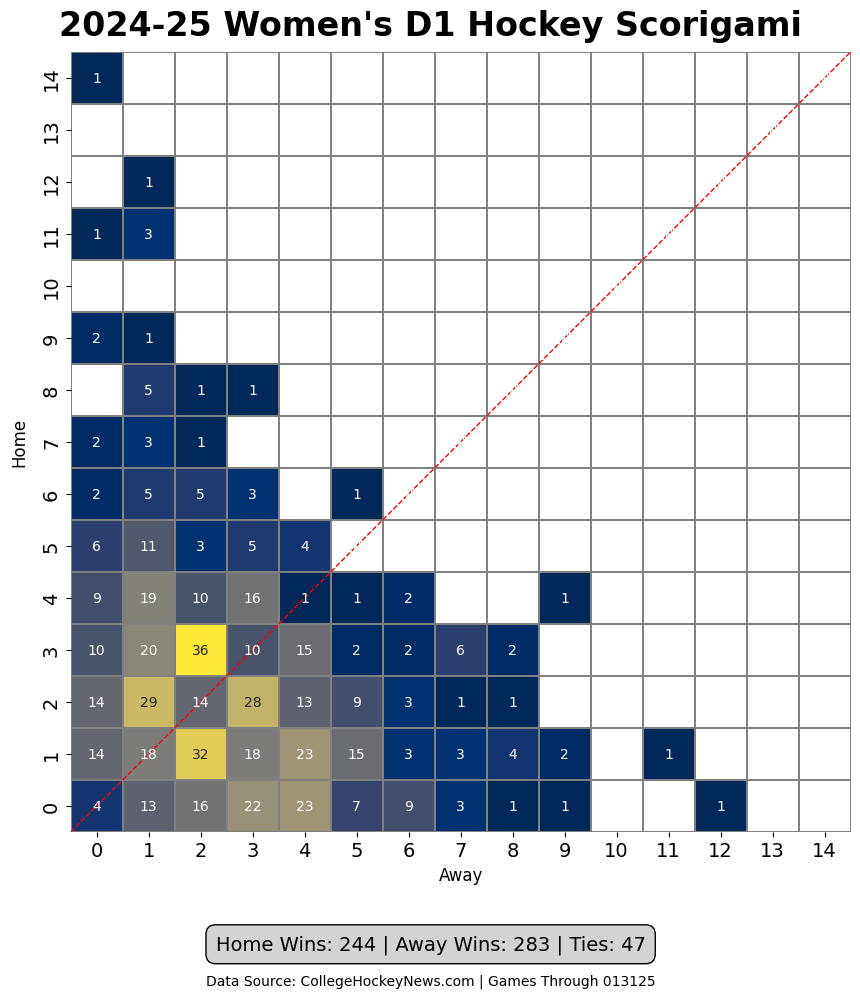

In [18]:
# Call the function
create_scorigami_plot(filtered_data, today_ns)

## All Time Scorigami (through 2024 currently) - Home and Away Axis

In [19]:
all_time_path = os.path.join('..', '..', 'data', 'vault', 'all_time_results_table_end_2024.csv')
all_time_df = pd.read_csv(all_time_path)

# Drop any rows with null score values
all_time_df.dropna(subset=['Home_Score', 'Away_Score'], inplace=True)

# Drop Rows marked as Exhibition
all_time_df = all_time_df[all_time_df['Conference'] != 'Exhibition']

# make sure Date is a datetime object
all_time_df['Date'] = pd.to_datetime(all_time_df['Date'])

# Make sure scores are integers
all_time_df['Home_Score'] = all_time_df['Home_Score'].astype(int)
all_time_df['Away_Score'] = all_time_df['Away_Score'].astype(int)

# all_time_df.head()
# all_time_df.tail()
# Length
print(len(all_time_df))

55801


C:\Users\jbanc\AppData\Local\Temp\ipykernel_7268\831098231.py:2: DtypeWarning: Columns (43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  all_time_df = pd.read_csv(all_time_path)


## All Time Plots with Home-Away Structure like current season

In [20]:
# ## REFACTOR TO DEFINE ERAS AND CREATE A FUNCTION TO FILTER DATA BY ERA THEN CREATE PLOTS

# Define the ranges for each era
eras = {
    "Pre-Depression Era": ('1900-01-01', '1930-06-30'),
    "Pre-Tournament Era": ('1930-07-01', '1947-07-01'),
    "Four Team Tourney Era": ('1947-07-01', '1977-07-01'),
    "Early Modern Era": ('1977-07-02', '1989-07-01'),
    "1990s": ('1989-07-02', '1999-07-01'),
    "2000s": ('1999-07-02', '2009-07-01'),
    "2010s": ('2009-07-02', '2019-07-01'),
    "2020s": ('2019-07-02', '2023-07-01')
}

# Calculate the global maximum score for both home and away teams

# Drop Exhibition Outliers
all_time_df = all_time_df[all_time_df['Conference'] != 'Exhibition']

global_max_home_score = all_time_df['Home_Score'].max()
global_max_away_score = all_time_df['Away_Score'].max()
global_max_score = (max(global_max_home_score, global_max_away_score))+1



In [21]:
# from matplotlib.colors import LogNorm, ListedColormap
# import seaborn as sns
# import matplotlib.pyplot as plt
# import os
# import numpy as np

# Function to filter data based on a given date range
def filter_data_by_era(df, start_date, end_date):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Filter data within the date range
    filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    # Exclude exhibition games
    filtered_df = filtered_df[filtered_df['Conference'] != 'Exhibition']
    
    return filtered_df



In [22]:
from matplotlib.colors import LogNorm, ListedColormap, PowerNorm
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

def plot_scorigami(filtered_data, era_name, global_max_score, start_date, end_date):
    # Create a pivot table to aggregate game counts for each score combination
    score_combinations = pd.pivot_table(
        filtered_data, 
        index='Home_Score', 
        columns='Away_Score', 
        values='Date', 
        aggfunc='count', 
        fill_value=0
    )
    
    # Create a custom color palette with transparency for zero counts
    cmap = sns.color_palette(palette=set_pallette, as_cmap=True)
    cmap_with_transparency = ListedColormap([(0, 0, 0, 0)] + [cmap(i) for i in range(1, cmap.N)])
    
    # Set up the figure and axes using plt.subplots() to avoid overlapping figures
    fig, ax = plt.subplots(figsize=figure_ratio)
    
    # Main title and subtitle
    fig.suptitle(f'NCAA Hockey Scorigami: {era_name}', fontsize=24, fontweight='bold')
    # Simplify start_date and end_date for the subtitle to just the year
    # make sure the dates are datetime objects
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    start_year = start_date.strftime('%Y')
    # Start year as integer
    start_year_int = int(start_year)
    start_year_pt_2 = start_year_int + 1
    # take the last two digits of the year
    start_year_pt_2 = str(start_year_pt_2)[2:]
    end_year = end_date.strftime('%Y')
    subtitle_text = f"From {start_year}/{start_year_pt_2} Season to {end_year} | Total Games: {len(filtered_data)}"
    fig.text(0.5, 0.92, subtitle_text, ha='center', fontsize=14, color='black')

    # Adjust spacing to reduce the gap between title and plot
    plt.subplots_adjust(top=0.90)

    # Dynamically adjust the axes based on the global maximum score
    all_scores = range(global_max_score + 1)
    
    sns.heatmap(
    score_combinations.reindex(index=all_scores, columns=all_scores, fill_value=0),
    annot=True, cmap=cmap_with_transparency, fmt="d", linewidths=.25,
    linecolor='gray', cbar=False, square=True, ax=ax,
    norm=PowerNorm(gamma=0.5)
    )
    # sns.heatmap(
    #     score_combinations.reindex(index=all_scores, columns=all_scores, fill_value=0),
    #     annot=True, cmap=cmap_with_transparency, fmt="d", linewidths=.25,
    #     linecolor='gray', cbar=False, square=True, ax=ax,
    #     norm=LogNorm(vmin=1, vmax=score_combinations.max().max())
    # )

    # Invert y-axis to ensure (0, 0) is at the bottom-left
    ax.invert_yaxis()
    ax.set_xlabel('Away', fontsize=12)
    ax.set_ylabel('Home', fontsize=12, rotation=90, labelpad=10)

    # Set consistent axis limits for every plot
    ax.set_xlim(0, global_max_score)
    ax.set_ylim(0, global_max_score)

    # Update tick labels for better readability
    ax.set_xticks(np.arange(0.5, global_max_score + 1, 1))
    ax.set_xticklabels(all_scores, fontsize=10)
    ax.set_yticks(np.arange(0.5, global_max_score + 1, 1))
    ax.set_yticklabels(all_scores, fontsize=10)

    # Add a diagonal line for parity
    ax.plot([0, global_max_score], [0, global_max_score], color='red', linestyle='--', linewidth=1)
    
    # Save the plot
    output_path = os.path.join(scor_o_path, f'scorigami_{era_name}.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


In [23]:
# Ensure Date is a datetime object to avoid errors
all_time_df['Date'] = pd.to_datetime(all_time_df['Date'])


# # Generate plots for each era
# for era_name, (start_date, end_date) in eras.items():
#     filtered_data = filter_data_by_era(all_time_df, start_date, end_date)
#     plot_scorigami(filtered_data, era_name, global_max_score, start_date, end_date)


# Create all time Charts with Just Winning and Losing Teams on Axis - Ignore Home Away

In [24]:
# all_time_df.tail()

# Save the data to a csv file for manual review
all_time_df.to_csv('../../data/vault/all_time_results_table_end_2024.csv')

# Make sure the columns are correct formats

# all_time_df.dtypes

In [25]:
# Transform datafram to have Winning and Losing Teams and Scores to ultimately create a traditional scorigami plot

# Create a copy of the original dataframe
df = all_time_df.copy()

# Filter out all games with missing scores
df = df.dropna(subset=['Home_Score', 'Away_Score'])
# Filter out an games marked as Exhibition or with empty strings
df = df[df['Conference'] != 'Exhibition']
df = df[df['Conference'] != '']


# Transform the data
df['Winning_Team'] = np.where(df['Home_Score'] >= df['Away_Score'], df['Home_Team'], df['Away_Team'])
df['Winning_Score'] = np.where(df['Home_Score'] >= df['Away_Score'], df['Home_Score'], df['Away_Score'])
df['Losing_Team'] = np.where(df['Home_Score'] <= df['Away_Score'], df['Home_Team'], df['Away_Team'])
df['Losing_Score'] = np.where(df['Home_Score'] <= df['Away_Score'], df['Home_Score'], df['Away_Score'])
df.drop(columns=['Home_Team', 'Home_Team_Link', 'Home_Score', 
                 'Away_Team', 'Away_Team_Link', 'Away_Score'], inplace=True)

# Define the ranges for each era
eras = {
    "Pre-Depression Era": ('1900-01-01', '1930-06-30'),
    "Pre-Tournament Era": ('1930-07-01', '1947-07-01'),
    "Four Team Tourney Era": ('1947-07-01', '1977-07-01'),
    "Early Modern Era": ('1977-07-01', '1989-07-01'),
    "1990s": ('1989-07-01', '1999-07-01'),
    "2000s": ('1999-07-01', '2009-07-01'),
    "2010s": ('2009-07-01', '2019-07-01'),
    "2020s": ('2019-07-01', '2024-07-01'),
    "All Time": ('1900-01-01', '2024-07-01')
}

# Calculate the global maximum score for both home and away teams
global_max_home_score = df['Winning_Score'].max()
global_max_away_score = df['Losing_Score'].max()
global_max_score = (max(global_max_home_score, global_max_away_score))
global_range_top = global_max_score + 1

# Define the global maximum scores
x_max = df['Losing_Score'].max()
y_max = df['Winning_Score'].max()



# Make sure the 'Date' column is datetime
df['Date'] = pd.to_datetime(df['Date'])


In [26]:
## Create the Heatmap for the Traditional Scorigami Plot

set_pallette = "cividis"
pallette = set_pallette

# Create a pivot table to aggregate game counts for each score combination
traditional_score_combinations = pd.pivot_table(
    df, 
    index='Winning_Score', 
    columns='Losing_Score', 
    values='Date', 
    aggfunc='count', 
    fill_value=0
)

# Fill in any missing score combinations with zeros
all_scores = np.arange(0, global_max_score + 1)

traditional_score_combinations = traditional_score_combinations.reindex(index=all_scores, columns=all_scores, fill_value=0)

# Ensure pivot table values are integers
traditional_score_combinations = traditional_score_combinations.astype(int)


# Show the traditional score combinations
# traditional_score_combinations

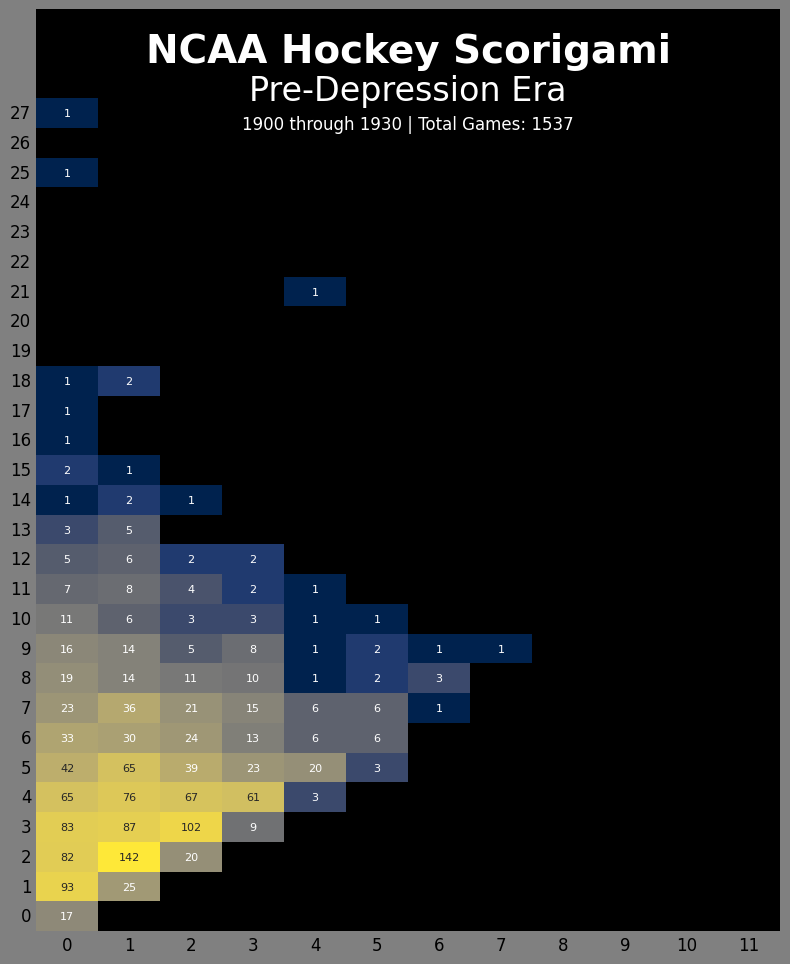

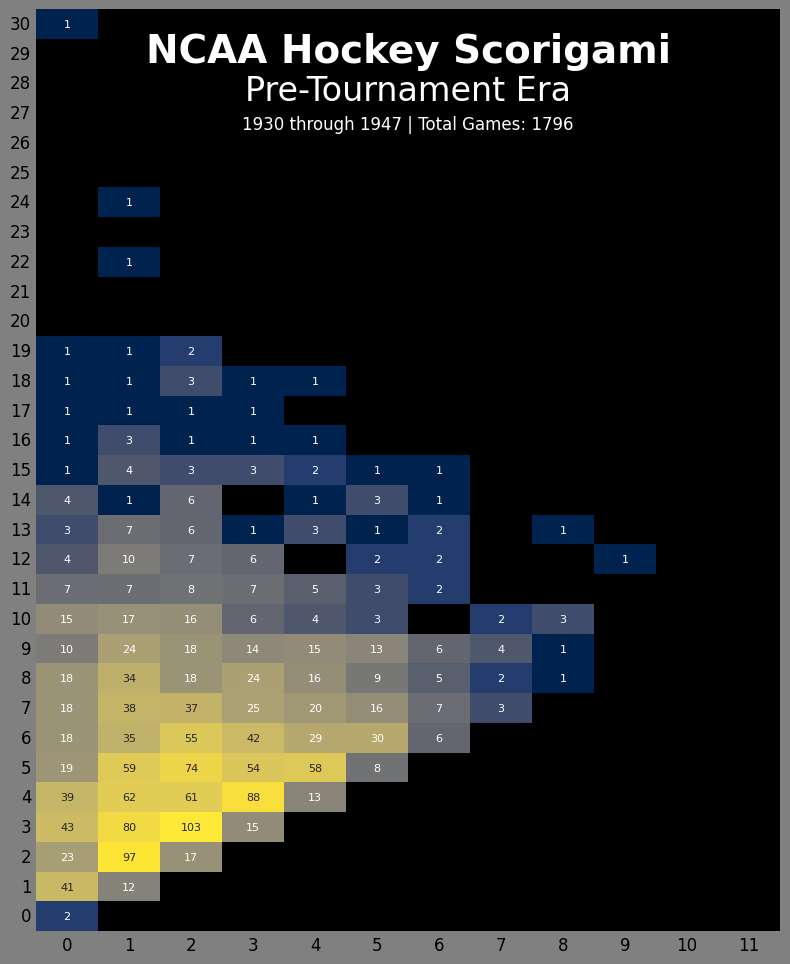

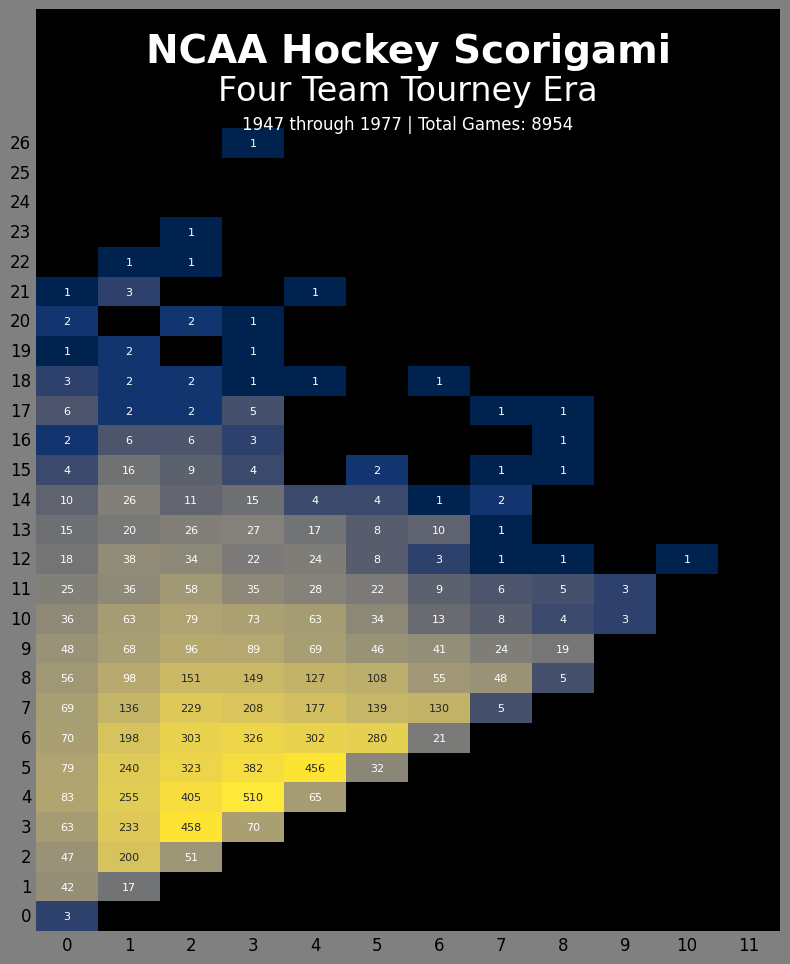

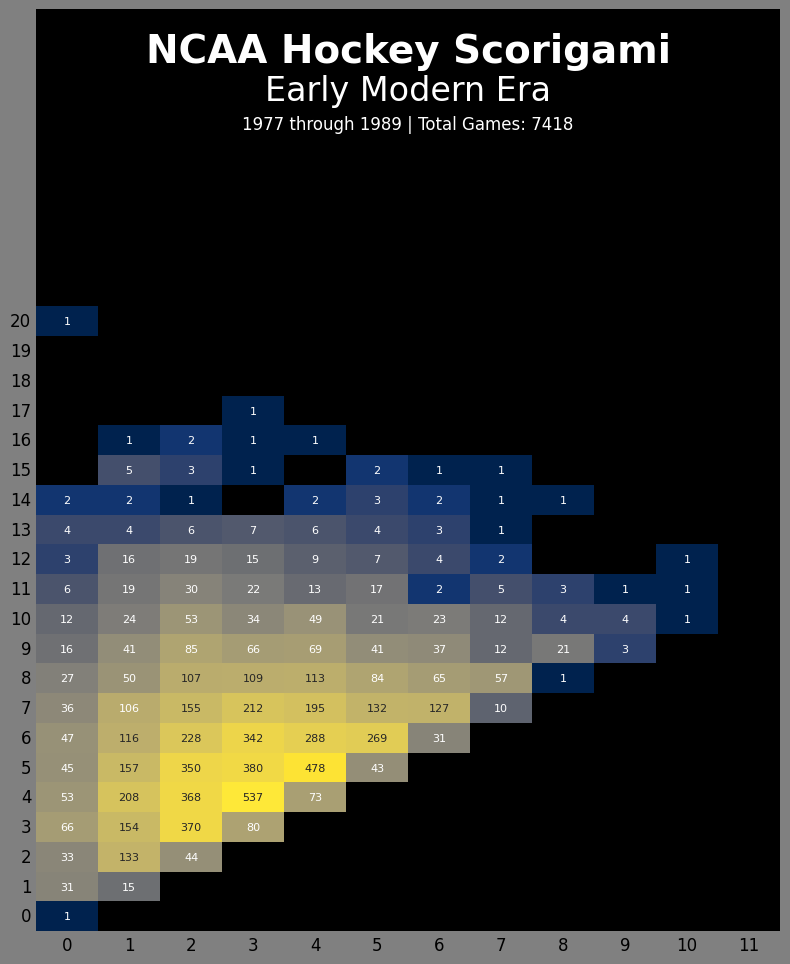

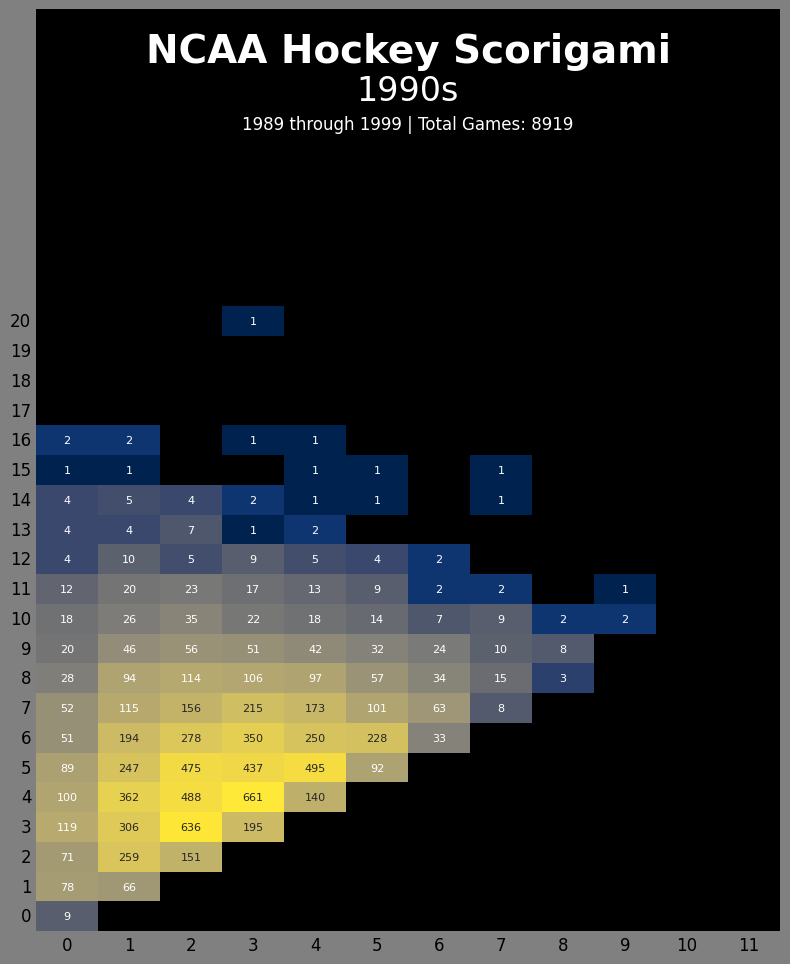

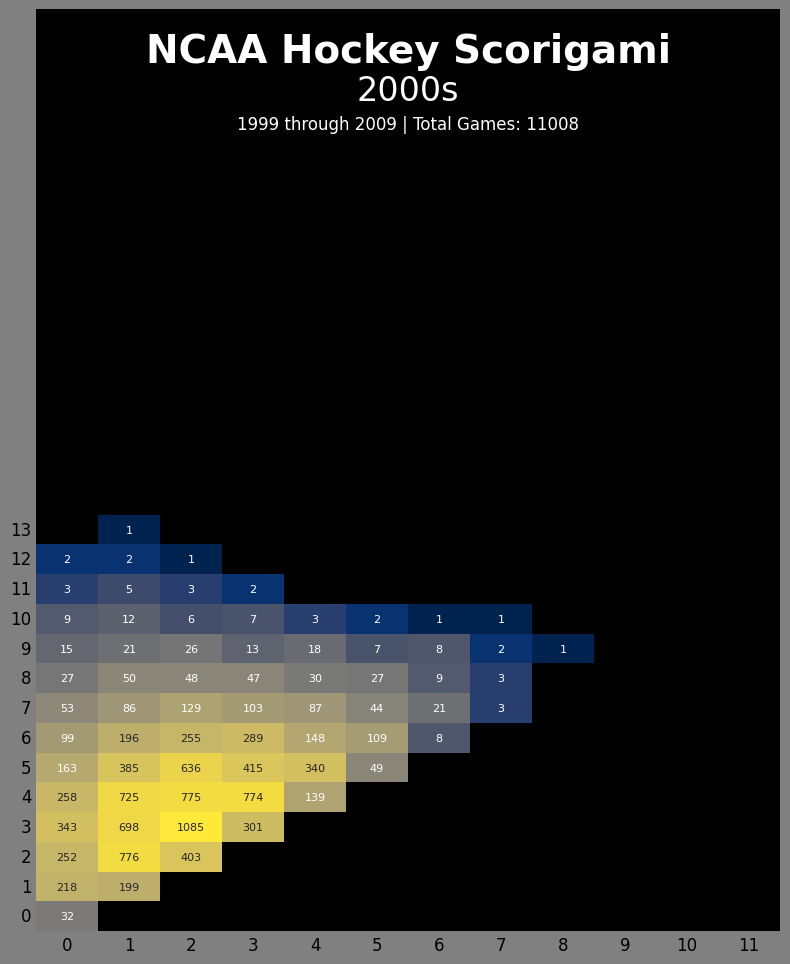

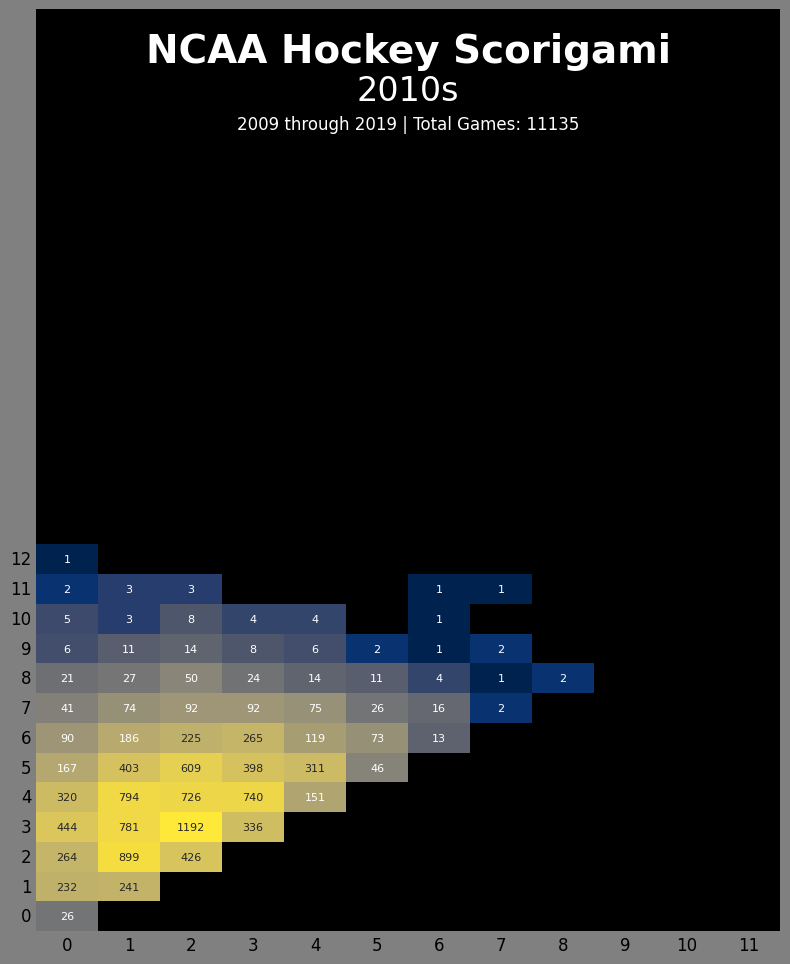

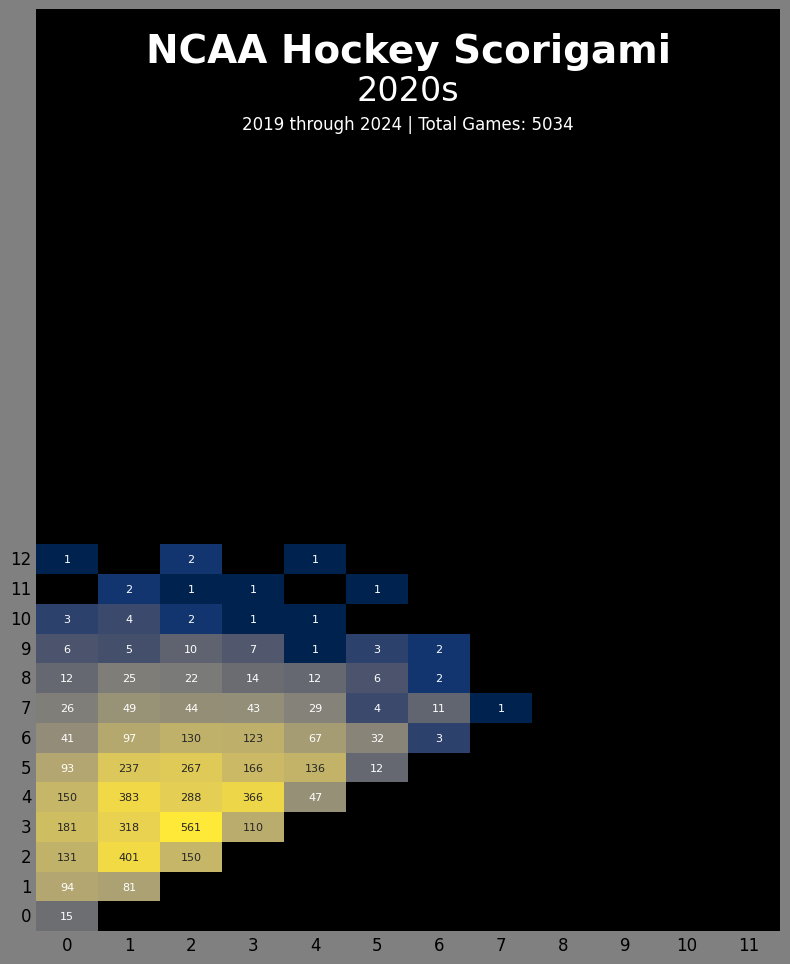

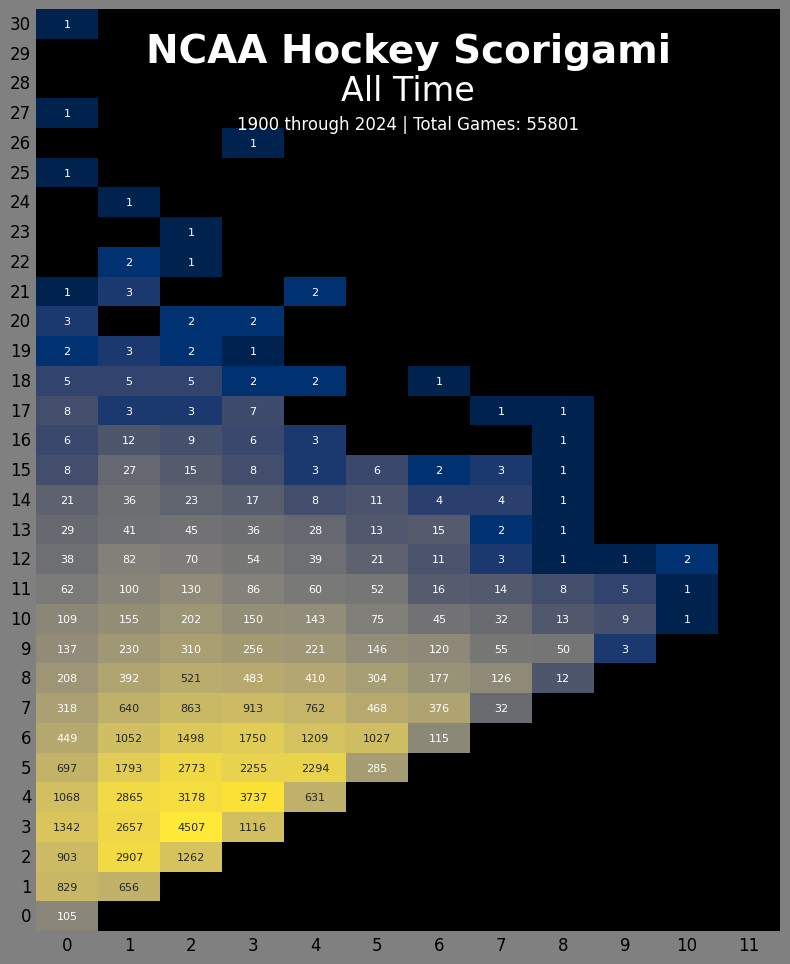

In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def create_scorigami_heatmap(data, start_date, end_date, era_name, palette, figure_ratio):
    # Filter data for the given time range
    era_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
    
    # Calculate the maximum score for the filtered era
    max_score = max(era_data['Winning_Score'].max(), era_data['Losing_Score'].max())
    all_scores = np.arange(0, max_score + 1)

    # Create a pivot table of Winning_Score vs Losing_Score
    score_counts = era_data.pivot_table(
        index='Winning_Score', columns='Losing_Score', 
        aggfunc='size', 
        fill_value=0
    )
    
    # Ensure all possible scores are included as rows and columns
    score_counts = score_counts.reindex(index=all_scores, columns=all_scores, fill_value=0)
    score_counts = score_counts.astype(int)  # Ensure values are integers

    # set the axis limits using the global maximum score
    x_max = era_data['Losing_Score'].max()
    y_max = era_data['Winning_Score'].max()

    
    # Define the figure size
    fig, ax = plt.subplots(figsize=figure_ratio)

    # set the background color of the entire figure
    fig.patch.set_facecolor('grey')

    # Set the background color of the plot area
    ax.set_facecolor('black')
    
    ##########################################
    ### NEEDS WORK
    ##########################################
    # Main Title and Subtitle
    start_year = pd.to_datetime(start_date).strftime('%Y-%y')
    end_year = pd.to_datetime(end_date).strftime('%Y-%y')
    total_games = era_data.shape[0]

    # fig.suptitle(f'NCAA Hockey Scorigami: {era_name}', fontsize=20, fontweight='bold')
    # subtitle_text = f"From {start_year} to {end_year} | Total Games: {total_games}"
    # fig.text(0.5, 0.93, subtitle_text, ha='center', fontsize=12, color='black')




#############################################################
    # # Ensure global_range_top and x_max are defined before using this snippet
    # global_range_top = score_counts.index.max() + 1  # Global max for y-axis
    
    # # Mask zeros for better readability
    mask = score_counts == 0

    # # Set the range to be the global maximum score for each axis
    # all_scores = range(global_range_top)

    # Create heatmap
    sns.heatmap(
        # Just trying something
        score_counts, cmap=palette, mask=mask,
        
        cbar=False, linewidths=0.0, ax=ax,
        annot=True, fmt='d', annot_kws={'fontsize': 8},
        norm = LogNorm(vmin=1, vmax=score_counts.values.max()),
        xticklabels=all_scores, yticklabels=all_scores
    )

    # Set axis limits to match global range
    ax.set_xlim(0, 12)  # x-axis limit
    ax.set_ylim(0, global_max_score+1)  # y-axis limit

    # Remove gridlines
    ax.grid(False)
    
    # # Remove axis labels
    ax.set_xlabel("")
    ax.set_ylabel("")



    # y_max_temp = max_score
    # # Create tick positions to align with the cell edges
    # tick_positions = np.arange(0.0, max_score + 1.0, 1)  
    # # Set ticks to align with edges of cells
    # ax.set_xticks(tick_positions)
    # ax.set_yticks(tick_positions)

    # Remove Tick Marks if I can't make them look good
    ax.tick_params(axis='both', which='both', length=0)
    # Set Font size for tick labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)


    # Rotate y axis tick labels for better readability
    plt.yticks(rotation=0)

    # Title (centered and bold)
    ax.text(
        0.5, 0.975,  # Position relative to the axes
        "NCAA Hockey Scorigami",  # Title
        ha='center', va='top',  # Center alignment
        transform=ax.transAxes,  # Position relative to the axes
        color='white',  # White text
        fontsize=28,  # Larger font for title
        fontweight='bold',  # Bold title
    )

    # Subtitle (centered and not bold)
    ax.text(
        0.5, 0.93,  # Slightly below the title
        f"{era_name}",  # Subtitle
        ha='center', va='top',  # Center alignment
        transform=ax.transAxes,  # Position relative to the axes
        color='white',  # White text
        fontsize=24,  # Smaller font for subtitle
        fontweight='normal',  # Regular (not bold) subtitle
    )

    # remove last 3 digits of the start_year and end_year strings
    start_year = start_year[:-3]
    end_year = end_year[:-3]
    # Informational lines (right-aligned)
    ax.text(
        0.5, 0.885,

        f"{start_year} through {end_year} | " # Era date range
        f"Total Games: {total_games}"
        ,
        ha='center', va='top',
        transform=ax.transAxes,
        color='white',
        fontsize=12,  # Smaller font size for details
        linespacing=1.2
    )

    # Improve spacing
    plt.tight_layout(rect=[0, 0, 1, 0.975])


    
    # Save the figure
    save_path = os.path.join(scor_o_path, f"scorigami_{era_name.replace(' ', '_')}.png")
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()

# Example usage (adjust based on your dataset):
# create_scorigami_heatmap(df, "1901-01-01", "1930-12-31", "Pre-Depression Era", "viridis", (10, 15))

# # Generate plots for each era
for era_name, (start_date, end_date) in eras.items():
    create_scorigami_heatmap(df, start_date, end_date, era_name, set_pallette, figure_ratio)


## POSSIBLE DELETE BELOW

In [28]:

### OLD AND UGLY BUT FUNCTIONAL
# # Function to create and save a heatmap for a given era
# def create_scorigami_heatmap(data, start_date, end_date, era_name, palette, ratio):
#     # Filter data for the given time range
#     era_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
    
#     # Create a pivot table of Winning_Score vs Losing_Score
#     score_counts = era_data.pivot_table(
#         index='Winning_Score', columns='Losing_Score', 
#         aggfunc='size', fill_value=0
#     )
    
#     # Define the figure size
#     fig, ax = plt.subplots(figsize=figure_ratio)
    
#         ########## Main title and subtitle ##########
#     ## Create strings from the the start and end dates to display the years
#     start_date = pd.to_datetime(start_date)
    
#     start_year = start_date.strftime('%Y') # String of the start year example: 1901-02
    
#     start_year_int = int(start_year) # Start year as integer
    
#     start_year_pt_2 = start_year_int + 1 # Get the second part of the year example: 1901-02 -> 1902
    
#     start_year_pt_2 = str(start_year_pt_2)[2:] # take the last two digits of the year
    
#     start_string = f"{start_year}/{start_year_pt_2}" # Create the string for the subtitle

#     # Same for the end year
#     end_date = pd.to_datetime(end_date)
#     end_year = end_date.strftime('%Y')
#     end_year_int = int(end_year)
#     end_year_pt_2 = end_year_int + 1
#     end_year_pt_2 = str(end_year_pt_2)[2:]
#     end_string = f"{end_year}-{end_year_pt_2}"



    


#     fig.suptitle(f'Traditional Scorigami: {era_name}', fontsize=24, fontweight='bold')
# ### LIKELY UNNECESSARY
#     # start_year = pd.to_datetime(start_date).strftime('%Y')
#     # end_year = pd.to_datetime(end_date).strftime('%Y')
# #####
#     subtitle_text = f"From {start_string} to {end_string} | Total Games: {len(traditional_score_combinations)}"
#     fig.text(0.5, 0.92, subtitle_text, ha='center', fontsize=14, color='black')

#     # Adjust spacing to reduce the gap between title and plot
#     # plt.subplots_adjust(top=0.90)
    
#     # Mask zeros to display in black/gray
#     mask = score_counts == 0
#     sns.heatmap(
#         score_counts, cmap=palette, mask=mask, square=True,
#         cbar_kws={'label': 'Frequency'}, linewidths=0.5, ax=ax,
#         annot=True, fmt='d', annot_kws={'fontsize': 8},
#         # mask color to black
#         cbar=False, linecolor='gray', norm=LogNorm(vmin=1, vmax=score_counts.max().max())

#     )
    
#     # Add labels and title
#     ax.set_title(f"Scorigami Heatmap: {era_name}")

#     # Invert y axis to match traditional scorigami layout
#     ax.invert_yaxis()
#     # Remove the color bar
#     # ax.collections[0].colorbar.remove()

    


#     # add text annotation to the cells
#     for i in range(score_counts.shape[0]):
#         for j in range(score_counts.shape[1]):
#             ax.text(j+0.5, i+0.5, score_counts.iloc[i, j], ha='center', va='center', fontsize=8)
    
#     # Adjust layout and save the figure
#     plt.tight_layout()
#     save_path = os.path.join(scor_o_path, f"scorigami_{era_name.replace(' ', '_')}.png")
#     plt.savefig(save_path, dpi=300)
#     plt.show()
#     plt.close()

# # Convert the 'Date' column to datetime
# df['Date'] = pd.to_datetime(df['Date'])


# # Loop through the eras and create heatmaps
# for era_name, (start_date, end_date) in eras.items():
#     create_scorigami_heatmap(df, start_date, end_date, era_name, set_pallette, figure_ratio)

In [29]:
# # Create a new columns to store the winning team and winning score
# df['Winning_Team'] = np.where(df['Home_Score'] > df['Away_Score'], df['Home_Team'], df['Away_Team'])
# df['Winning_Score'] = np.where(df['Home_Score'] > df['Away_Score'], df['Home_Score'], df['Away_Score'])
# # New Columns for Losing Team and Score
# df['Losing_Team'] = np.where(df['Home_Score'] < df['Away_Score'], df['Home_Team'], df['Away_Team'])
# df['Losing_Score'] = np.where(df['Home_Score'] < df['Away_Score'], df['Home_Score'], df['Away_Score'])

# # Drop the Home and Away Team and Score columns
# df.drop(columns=['Home_Team', 'Home_Team_Link', 'Home_Score', 'Away_Team', 'Away_Team_Link', 'Away_Score'], inplace=True)

# # Rearrange the columns for better readability
# df = df[['Date', 'Conference', 'Game_Notes', 'Winning_Team', 'Winning_Score', 
#         'Losing_Team', 'Losing_Score', 'OT', 'Box_Link', 'Metrics_Link']]

# # df.tail()

In [30]:
# def plot_traditional_scorigami(traditional_score_combinations, era_name, global_max_score, start_date, end_date):
#     # Create a pivot table to aggregate game counts for each score combination
#     score_combinations = pd.pivot_table(
#         filtered_data, 
#         index='Winning_Score', 
#         columns='Losing_Score', 
#         values='Date', 
#         aggfunc='count', 
#         fill_value=0
#     )

    
#     # Determine the maximum losing score
#     losing_scores = traditional_score_combinations[['Winning_Score', 'Losing_Score']].min(axis=1)
#     max_losing_score = filtered_data['Losing_Score'].max()

#     max_losing_score += 1  # Extend by 1 to ensure space

#     # Create a custom color palette with transparency for zero counts
#     cmap = sns.color_palette(palette=set_pallette, as_cmap=True)
#     cmap_with_transparency = ListedColormap([(0, 0, 0, 0)] + [cmap(i) for i in range(1, cmap.N)])
    
#     # Set up the figure and axes using plt.subplots() to avoid overlapping figures
#     fig, ax = plt.subplots(figsize=figure_ratio)
    
#     ########## Main title and subtitle ##########
#     ## Create strings from the the start and end dates to display the years
#     start_date = pd.to_datetime(start_date)
#     # String of the start year example: 1901-02
#     start_year = start_date.strftime('%Y')
#     # Start year as integer
#     start_year_int = int(start_year)
#     # Get the second part of the year example: 1901-02 -> 1902
#     start_year_pt_2 = start_year_int + 1
#     # take the last two digits of the year
#     start_year_pt_2 = str(start_year_pt_2)[2:]
#     # Create the string for the subtitle
#     start_string = f"{start_year}/{start_year_pt_2}"

#     # Same for the end year
#     end_date = pd.to_datetime(end_date)
#     end_year = end_date.strftime('%Y')
#     end_year_int = int(end_year)
#     end_year_pt_2 = end_year_int + 1
#     end_year_pt_2 = str(end_year_pt_2)[2:]
#     end_string = f"{end_year}/{end_year_pt_2}"



    


#     fig.suptitle(f'Traditional Scorigami: {era_name}', fontsize=24, fontweight='bold')
#     start_year = pd.to_datetime(start_date).strftime('%Y')
#     end_year = pd.to_datetime(end_date).strftime('%Y')
#     subtitle_text = f"From {start_string} to {end_string} | Total Games: {len(traditional_score_combinations)}"
#     fig.text(0.5, 0.92, subtitle_text, ha='center', fontsize=14, color='black')

#     # Adjust spacing to reduce the gap between title and plot
#     plt.subplots_adjust(top=0.90)

#     # Dynamically adjust the axes based on the global maximum score
#     all_scores = range(global_max_score + 1)
#     sns.heatmap(
#         score_combinations.reindex(index=all_scores, columns=all_scores, fill_value=0),
#         annot=True, cmap=cmap_with_transparency, fmt="d", linewidths=.25,
#         linecolor='gray', cbar=False, square=True, ax=ax,
#         norm=PowerNorm(gamma=0.5)
#     )

#     # Invert y-axis to ensure (0, 0) is at the bottom-left
#     ax.invert_yaxis()

#     # Set dynamic y-axis limits based on the maximum losing score
#     ax.set_ylim(0, max_losing_score)

#     # Set consistent x-axis limits
#     ax.set_xlim(0, global_max_score)

#     # Update tick labels for better readability
#     ax.set_xticks(np.arange(0.5, global_max_score + 1, 1))
#     ax.set_xticklabels(all_scores, fontsize=10)
#     ax.set_yticks(np.arange(0.5, max_losing_score + 1, 1))
#     ax.set_yticklabels(range(max_losing_score + 1), fontsize=10)

#     # Add a diagonal line for parity
#     ax.plot([0, global_max_score], [0, max_losing_score], color='red', linestyle='--', linewidth=1)

#     # Save the plot
#     output_path = os.path.join(scor_o_path, f'traditional_scorigami_{era_name}.png')
#     plt.savefig(output_path, dpi=300, bbox_inches='tight')
#     plt.show()


In [31]:
# for era_name, (start_date, end_date) in eras.items():
#     filtered_data = filter_data_by_era(df, start_date, end_date)
#     plot_traditional_scorigami(filtered_data, era_name, global_max_score, start_date, end_date)


